In [1]:
import os
if os.name != 'posix':
    %matplotlib ipympl
else:
    %matplotlib notebook
import numpy as np
import cmath
import matplotlib.pyplot as plt
import h5py

print(os.getpid())
%cd ../

import pylib.mix as mix
import pylib.measurement as mse
import cvxpy as cp
import pylib.qsvt_angles as qsvt_a

colors_ = ["blue", "red", "green", "gray", "black"]

11228
/media/work/docs/codes/QuCF/scripts-py


In [2]:
for i in range(30):
    plt.close()

In [3]:
# ----------------------------------------------------------------------
# Compute coefficients for the estimation of the QSVT angles necessary
# for the inversion of a matrix with an arbitrary condition number.
# ----------------------------------------------------------------------

In [3]:
# ----------------------------------------------------------------------
# --- Supplemental functions ---
# ----------------------------------------------------------------------
def extract_env(phis_sh):
    N = len(phis_sh)
    pos_peaks = np.zeros(N)
    neg_peaks = np.zeros(N)
    inds_pos = np.zeros(N)
    inds_neg = np.zeros(N)
    count_pos = 0
    count_neg = 0
    prev_peak = None
    for ii in range(N):
        temp = phis_sh[ii]
        
        if np.abs(temp) <= 1e-12:
            if prev_peak is None:
                prev_peak = -1
                neg_peaks[count_neg] = temp
                inds_neg[count_neg] = ii
                count_neg += 1
            else:
                if prev_peak > 0.0:
                    prev_peak = -1
                    neg_peaks[count_neg] = temp
                    inds_neg[count_neg] = ii
                    count_neg += 1
                else:
                    prev_peak = +1
                    pos_peaks[count_pos] = temp
                    inds_pos[count_pos] = ii
                    count_pos += 1 
        else:
            if temp < 0.0:
                neg_peaks[count_neg] = temp
                inds_neg[count_neg] = ii
                count_neg += 1
            else:
                pos_peaks[count_pos] = temp
                inds_pos[count_pos] = ii
                count_pos += 1    
                         
    pos_peaks = pos_peaks[:count_pos]
    inds_pos = inds_pos[:count_pos]
    neg_peaks = neg_peaks[:count_neg]
    inds_neg = inds_neg[:count_neg]
    peaks = {
        "pos-v": pos_peaks,
        "pos-i": inds_pos,
        "neg-v": neg_peaks,
        "neg-i": inds_neg
    }
    return peaks


def plot_angles(ids_plot, xlim = None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    count_plot = -1
    for ii in ids_plot: 
        count_plot+= 1
        Nphis = len(dds_[ii]["phis"]) # even integer;
        x_array = np.array(range(Nphis)) - Nphis/2
        ax.plot(
            x_array, 
            dds_[ii]["phis"] - np.pi/2., 
            color=colors_[count_plot], 
            linewidth = 2, linestyle='-',
            label = "k = {:d}, log_e = {:d}".format(
                int(dds_[ii]["function-parameter"]),
                -int(np.log10(dds_[ii]["abs-error"]))
            )
        )
    plt.xlabel('i - N/2')
    plt.ylabel("phis - pi/2")
    if xlim is not None:
        plt.xlim(xlim)
    ax.legend()
    plt.grid(True)
    plt.show()
    return 


def plot_max(ids_plot):
    Npr = len(ids_plot)
    array_pos  = np.zeros(Npr)
    array_neg  = np.zeros(Npr)
    kappas     = np.zeros(Npr)
    count_pr = -1
    for ii in ids_plot: 
        count_pr += 1
        dd1 = dds_[count_pr]
        phis = dd1["phis"] - np.pi/2.
        array_pos[count_pr] = np.max(phis)
        array_neg[count_pr] = np.max(-phis)
        kappas[count_pr]    = dd1["function-parameter"]
    array_diff = array_neg - array_pos

    # --- Plot positive and negatives maximums ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kappas, array_pos, "b:", linewidth = 2, marker = "o", label = "pos")
    ax.plot(kappas, array_neg, "r:", linewidth = 2, marker = "o", label = "abs(neg)")
    plt.xlabel('kappa')
    plt.title("pos = max(phis-pi/2);   neg = max(pi/2 - phis)")
    ax.legend()
    plt.grid(True)
    plt.show()

    # --- Plot the difference between the positive and negatives maximums ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kappas, np.log10(array_diff), "b:", linewidth = 2, marker = "o")
    plt.xlabel('kappa')
    plt.title("log10(abs(neg) - pos)")
    plt.grid(True)
    plt.show()
    return

In [4]:
phis_ch    = np.array(dds_[id_comp_]["phis"])
range_full = np.array(range(len(phis_ch)))

# shifted QSVT angles:
phis_sh_ch = phis_ch - np.pi/2.

# chosen (shifted by pi/2) envelops:
peaks_ch   = extract_env(phis_sh_ch)

print("N-pos: {:d}".format(len(peaks_ch["pos-i"])))
print("N-neg: {:d}".format(len(peaks_ch["neg-i"])))

NameError: name 'dds_' is not defined

In [8]:
rr = range(0,20)

print(peaks_ch["pos-i"][rr])
print()
print(peaks_ch["pos-v"][rr])

print("\n\n---")
print(peaks_ch["neg-i"][rr])
print()
print(peaks_ch["neg-v"][rr])

[ 1.  3.  5.  7.  9. 11. 13. 15. 17. 19. 21. 23. 25. 27. 29. 31. 33. 35.
 37. 39.]

[ 4.441e-16  6.661e-16  2.220e-16  2.220e-16  4.441e-16  0.000e+00
  2.220e-16  2.220e-16  2.220e-16  4.441e-16  4.441e-16  4.441e-16
  4.441e-16  2.220e-16  2.220e-16  2.220e-16  2.220e-16 -2.220e-16
  2.220e-16  2.220e-16]


---
[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38.]

[-4.441e-16 -2.220e-16 -2.220e-16 -2.220e-16  0.000e+00 -2.220e-16
 -2.220e-16 -2.220e-16 -2.220e-16 -2.220e-16 -4.441e-16 -4.441e-16
 -4.441e-16 -2.220e-16 -2.220e-16 -2.220e-16 -2.220e-16 -4.441e-16
 -4.441e-16 -6.661e-16]


In [5]:
# -----------------------------------------
# --- Read data ----
# -----------------------------------------
mix.reload_module(qsvt_a)

id_case = 0

# the name of the output file:
fname_ = "QSVT-MI-estimation-coefs-case{:d}.hdf5".format(id_case)

# paths where pre-computed QSVT angles are saved and
#     where resulting parameters for the estimation of the QSVT angles will be saved:
path_root_       = "./tools/QSVT-angles/inversion/"
path_root_coefs_ = "./tools/QSVT-angles/inversion/ref-angles"
path_save_plots_ = path_root_ + "/saved-plots/"


if id_case == 0:
    # names of the .hdf5 files where pre-computed QSVT angles are saved:
    filenames_ = [
        # --- 
        "k40_eps13.hdf5",   # id = 0
        "k80_eps13.hdf5",   # id = 1 
        "k100_eps13.hdf5",  # id = 2
        "k150_eps13.hdf5",  # id = 3
        "k180_eps13.hdf5",  # id = 4
    ]

    # the projects used to compute the change in the QSVT angles' amplitudes:
    ids_main_ = [0,1,2,3,4]  

    # the project used to compute the shape of the QSVT angles:
    id_comp_ = 2

# read the QSVT angles computed using the L-BFGS approach [Dong-21-DOI:10.1103/PhysRevA.103.042419]:
dds_ = []
for ii in range(len(filenames_)):
    print("\n----------------------------------------")
    dds_.append(qsvt_a.read_angles(path_root_coefs_, filenames_[ii]))
del ii


----------------------------------------
Reading angles from the file 
./tools/QSVT-angles/inversion/ref-angles/k40_eps13.hdf5
when simulated:  01-22-2024 14:28:05

function-type: 		inversion
function-parity: 		1
param: 			40.000000
absolute error: 	1.151e-13
norm. factor: 		1.250e-01
Number of angles: 	3600

----------------------------------------
Reading angles from the file 
./tools/QSVT-angles/inversion/ref-angles/k80_eps13.hdf5
when simulated:  01-22-2024 14:13:54

function-type: 		inversion
function-parity: 		1
param: 			80.000000
absolute error: 	1.190e-13
norm. factor: 		1.250e-01
Number of angles: 	7200

----------------------------------------
Reading angles from the file 
./tools/QSVT-angles/inversion/ref-angles/k100_eps13.hdf5
when simulated:  01-22-2024 13:55:50

function-type: 		inversion
function-parity: 		1
param: 			100.000000
absolute error: 	1.018e-13
norm. factor: 		1.250e-01
Number of angles: 	9000

----------------------------------------
Reading angles from the

<IPython.core.display.Javascript object>


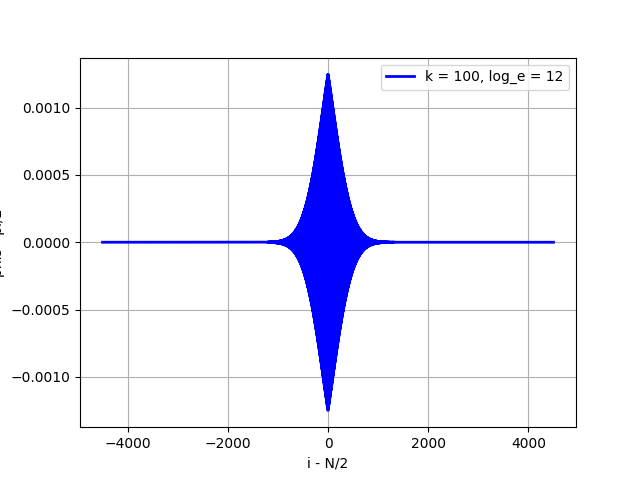

In [10]:
# -----------------------------------------
# --- Plot angles ----
# -----------------------------------------
# plot_angles([0,1], xlim = [-10, 10]) 
plot_angles([id_comp_]) 

<IPython.core.display.Javascript object>


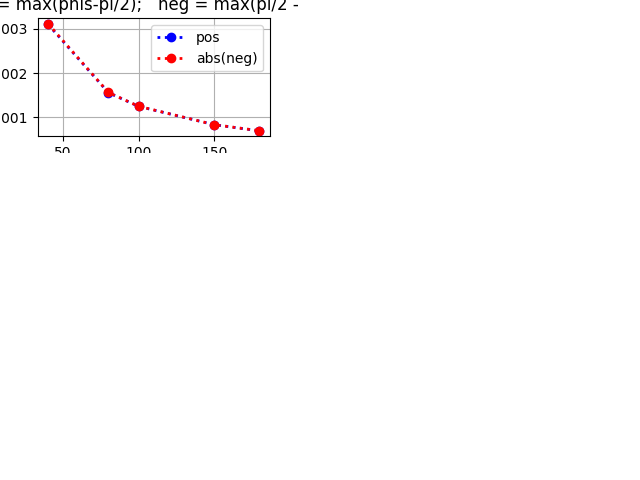

<IPython.core.display.Javascript object>


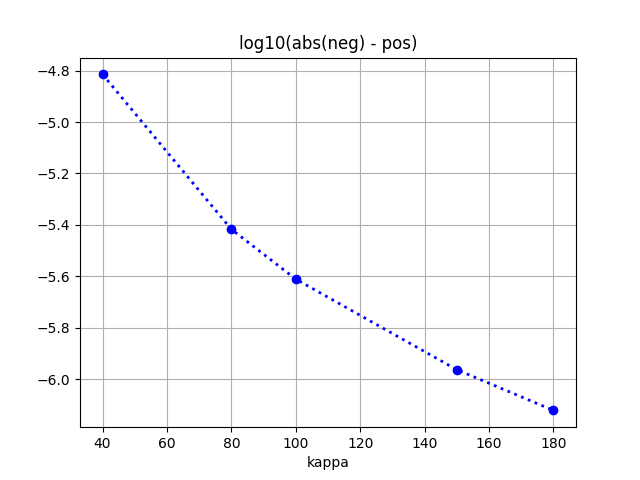

In [11]:
# ------------------------------------------
# --- Plot miximum values of the angles ----
# ------------------------------------------
plot_max(ids_main_)

--- Estimating  coefficients to predict maximum negative QSVT angles ---
max. abs. err: 5.722e-11


<IPython.core.display.Javascript object>


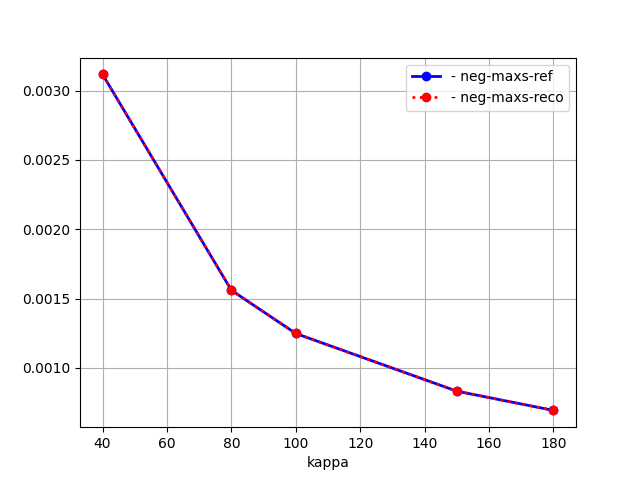

In [6]:
# ----------------------------------------------------------------------------------------
# --- COMPUTE the coefficients to describe the change in the maximum negative angle ---
# ----------------------------------------------------------------------------------------
def estimate_coefs_neg_amplitude(ids_chosen):
    def test_func(k, coefs):
        res_pol = coefs[0]
        for ii in range(1,Ncoefs):
            res_pol += coefs[ii] / k**ii
        return res_pol 
    # --------------------------------------------------
    print("--- Estimating  coefficients to predict maximum negative QSVT angles ---")
    Npr = len(ids_chosen)
    kappas   = np.zeros(Npr)
    neg_maxs = np.zeros(Npr)
    count_pr = -1
    for ii in ids_chosen:
        count_pr += 1
        dd1 = dds_[ii]
        phis = dd1["phis"] - np.pi/2.
        kappas[count_pr]    = dd1["function-parameter"]
        neg_maxs[count_pr] = -np.max(-phis)

    Ncoefs = 4
    coefs = cp.Variable(Ncoefs)
    objective = cp.Minimize(cp.sum_squares(test_func(kappas, coefs) - neg_maxs))
    prob = cp.Problem(objective)
    result = prob.solve()

    neg_maxs_rec = np.zeros(Npr)
    for ii in range(Npr):
        neg_maxs_rec[ii] = test_func(kappas[ii], coefs.value) 

    max_abs_err = np.max(np.abs(neg_maxs_rec - neg_maxs))
    print("max. abs. err: {:0.3e}".format(max_abs_err))

    # --- Plot the reconstructed amplitudes ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kappas, -neg_maxs,     "b-", linewidth = 2, marker = "o", label = "- neg-maxs-ref")
    ax.plot(kappas, -neg_maxs_rec, "r:", linewidth = 2, marker = "o", label = "- neg-maxs-reco")
    plt.xlabel('kappa')
    ax.legend()
    plt.grid(True)
    plt.show()
    
    return coefs.value

# --------------------------------------------------------------------------------------
coefs_A_ = estimate_coefs_neg_amplitude(ids_main_)

N_env-half-NEG: 2250
N_env-half-POS: 2250
full number of angles: 9000
N of neg. peaks: 4500
N of pos. peaks: 4500
The envelop for the kappa = 100 is taken.


<IPython.core.display.Javascript object>


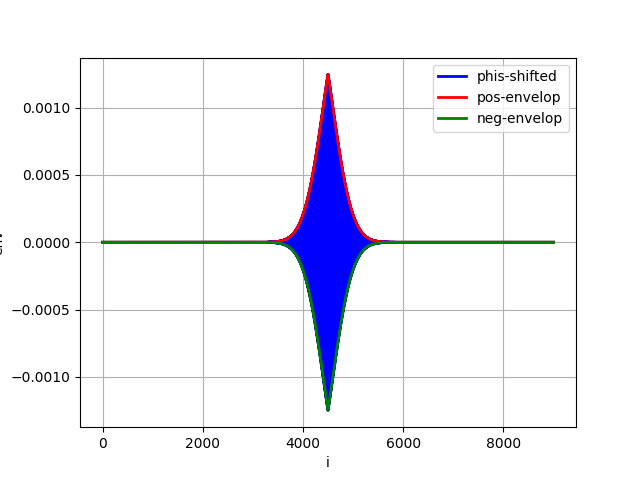

POS. ENV: max. absolute error: 1.137e-09
NEG. ENV: max. absolute error: 1.135e-09


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Reconstructing the QSVT angles ---
max-abs-err: 6.184e-13


<IPython.core.display.Javascript object>


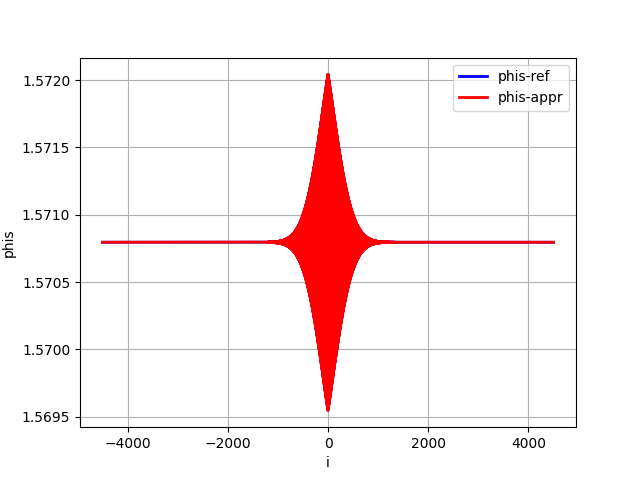

In [13]:
# ----------------------------------------------------------------------------------------
# --- Compute the coefficients to describe the shape (envelop) of the QSVT angles ---
# ----------------------------------------------------------------------------------------
def compute_shape(
    Ncoefs = 10, 
    flag_plot_envelop = True, 
    flag_plot_shape = True,
    flag_reconstruct = True
):
    # --------------------------------------------------------
    def test_func_even_Ch(x, a):
        res_pol = 0.
        for ii in range(Ncoefs):
            res_pol += a[ii] * np.cos((2*ii) * np.arccos(x))
        return res_pol

    def np_test_func_even_Ch(x, a):
        Nx = len(x)
        res_pol = np.zeros(Nx)
        for ix in range(Nx):
            res_pol[ix] = 0.
            for ii in range(Ncoefs):
                res_pol[ix] += a[ii] * np.cos((2*ii) * np.arccos(x[ix]))
        return res_pol
    # --------------------------------------------------------

    
    # chosen QSVT angles
    phis_ch    = np.array(dds_[id_comp_]["phis"])
    range_full = np.array(range(len(phis_ch)))
    
    # shifted QSVT angles:
    phis_sh_ch = phis_ch - np.pi/2.
    
    # chosen (shifted by pi/2) envelops:
    peaks_ch   = extract_env(phis_sh_ch)
    
    # chosen envelops: 
    full_env_neg = peaks_ch["neg-v"];
    max_v_neg    = np.max(np.abs(full_env_neg))
    
    full_env_pos = peaks_ch["pos-v"];
    max_v_pos    = np.max(np.abs(full_env_pos))
      
    # chosen indices of positive and negative envelops:
    range_env_pos = peaks_ch["pos-i"]
    range_env_neg = peaks_ch["neg-i"]
    
    # normalized envelops:
    full_norm_env_neg = full_env_neg / max_v_neg
    N_full_env_neg    = len(full_env_neg)
    
    full_norm_env_pos = full_env_pos / max_v_pos
    N_full_env_pos    = len(full_env_pos)
    
    # chosen half envelops:
    half_norm_env_neg  = full_norm_env_neg[0:N_full_env_neg//2]; 
    range_env_half_neg = range_env_neg[0:N_full_env_neg//2] 
    N_half_env_neg     = len(range_env_half_neg)
    print("N_env-half-NEG: {:d}".format(N_half_env_neg))
    
    half_norm_env_pos  = full_norm_env_pos[0:N_full_env_pos//2]; 
    range_env_half_pos = range_env_pos[0:N_full_env_pos//2] 
    N_half_env_pos     = len(range_env_half_pos)
    print("N_env-half-POS: {:d}".format(N_half_env_pos))
    
    print("full number of angles: {:d}".format(len(range_full)))
    print("N of neg. peaks: {:d}".format(N_full_env_neg))
    print("N of pos. peaks: {:d}".format(N_full_env_pos))
    
    # --- Plot the original envelop ---
    print("The envelop for the kappa = {:0.0f} is taken.".format(dds_[id_comp_]["function-parameter"]))
    
    if flag_plot_envelop:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(range_full,    phis_sh_ch,   color="b", linewidth = 2, linestyle='-',  label = "phis-shifted")
        ax.plot(range_env_pos, full_env_pos, color="r", linewidth = 2, linestyle='-',  label = "pos-envelop")
        ax.plot(range_env_neg, full_env_neg, color="g", linewidth = 2, linestyle='-',  label = "neg-envelop")
        ax.plot()
        plt.xlabel('i')
        plt.ylabel("env")
        ax.legend()
        plt.grid(True)
        plt.show()

    # --- Compute the coefficients ---
    x_neg = np.linspace(0.0, 1.0, N_half_env_neg)
    coefs_neg = cp.Variable(Ncoefs)
    objective = cp.Minimize(cp.sum_squares(
        test_func_even_Ch(x_neg,coefs_neg) - half_norm_env_neg
    ))
    prob = cp.Problem(objective)
    result = prob.solve()
    half_norm_env_neg_APPR = np_test_func_even_Ch(x_neg, coefs_neg.value)
    full_norm_env_neg_APPR = np.concatenate((
        half_norm_env_neg_APPR, np.flip(half_norm_env_neg_APPR)
    ))
    
    x_pos = np.linspace(0.0, 1.0, N_half_env_pos)
    coefs_pos = cp.Variable(Ncoefs)
    objective = cp.Minimize(cp.sum_squares(
        test_func_even_Ch(x_pos,coefs_pos) - half_norm_env_pos
    ))
    prob = cp.Problem(objective)
    result = prob.solve()
    half_norm_env_pos_APPR = np_test_func_even_Ch(x_pos, coefs_pos.value)
    full_norm_env_pos_APPR = np.concatenate((
        half_norm_env_pos_APPR, np.flip(half_norm_env_pos_APPR)
    ))

    # --- Maximum absolute errors ---
    print("POS. ENV: max. absolute error: {:0.3e}".format(
        np.max(np.abs(full_norm_env_pos_APPR - full_norm_env_pos))
    ))
    print("NEG. ENV: max. absolute error: {:0.3e}".format(
        np.max(np.abs(full_norm_env_neg_APPR - full_norm_env_neg))
    ))

    # --- Plot the reconstructed shape ---
    if flag_plot_shape:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(range_env_pos, full_norm_env_pos,      color="b", linewidth = 2, linestyle='-')
        ax.plot(range_env_pos, full_norm_env_pos_APPR, color="r", linewidth = 2, linestyle=':')
        plt.xlabel('x')
        plt.ylabel("pos. envelop")
        plt.grid(True)
        plt.show()
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(range_env_neg, full_norm_env_neg,      color="b", linewidth = 2, linestyle='-')
        ax.plot(range_env_neg, full_norm_env_neg_APPR, color="r", linewidth = 2, linestyle=':')
        plt.xlabel('x')
        plt.ylabel("neg. envelop")
        plt.grid(True)
        plt.show()

    # --- Reconstruct the QSVT angles ---
    phis_appr = None
    if flag_reconstruct:
        print("\n--- Reconstructing the QSVT angles ---")
#         Na = len(range_full)
#         phis_appr = np.ones(Na)
        
        phis_appr = np.zeros(len(range_full)//2)
        Nh = len(phis_appr)
        
        # set negative angles:
        for ii in range(N_half_env_neg):
            phis_appr[2*ii+1] = max_v_neg * full_norm_env_neg_APPR[ii]
            
        # set positive angles:
        for ii in range(N_half_env_pos):
            phis_appr[2*ii] = max_v_pos * full_norm_env_pos_APPR[ii]
          
        phis_appr = np.concatenate(
            (phis_appr, np.flip(phis_appr))
        )
        
        # shift the angles:
        phis_appr += np.pi/2.
        phis_appr_plot = np.array(phis_appr)

        # --- range ---
        Nh = len(range_full)//2
        range_full_ch   = range_full - Nh
        range_full_appr = np.array(range_full_ch)
        
        # --- Maximum absolute error ---
        abs_err = np.max(np.abs(phis_ch - phis_appr))
        print("max-abs-err: {:0.3e}".format(abs_err))

        # # --- Padding ---
        # padding_array = np.array([np.pi/2.] * 1001)
        # phis_appr_plot = np.concatenate(
        #     (padding_array, phis_appr, padding_array)
        # )
        # range_full_appr = np.array(range(
        #     len(phis_ch) + 2*len(padding_array)
        # ))
        # range_full_appr -= len(range_full_appr)//2
        
        # --- plot angles ---
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(range_full_ch,   phis_ch,        color="b", linewidth = 2, linestyle='-', label = "phis-ref")
        ax.plot(range_full_appr, phis_appr_plot, color="r", linewidth = 2, linestyle='-', label = "phis-appr")
        plt.xlabel('i')
        plt.ylabel("phis")
        # plt.xlim([-50, 50])
        ax.legend()
        plt.grid(True)
        plt.show()
    return coefs_neg.value, coefs_pos.value, N_half_env_neg, N_half_env_pos, phis_appr
# -----------------------------------------------------------------------------------------------------------------------
coefs_shape_neg_, coefs_shape_pos_, N_half_env_neg_, N_half_env_pos_, phis_appr_ = compute_shape(
    Ncoefs = 40, 
    flag_plot_envelop = True, 
    flag_plot_shape = True,
    flag_reconstruct = True
)

N_env-half: 2024
The envelop for the kappa = 100 is taken.
max. absolute error: 4.794e-13
N_env-half: 2024
The envelop for the kappa = 100 is taken.
max. absolute error: 4.634e-13
N_env-half: 2024
The envelop for the kappa = 100 is taken.
max. absolute error: 4.801e-13


<IPython.core.display.Javascript object>


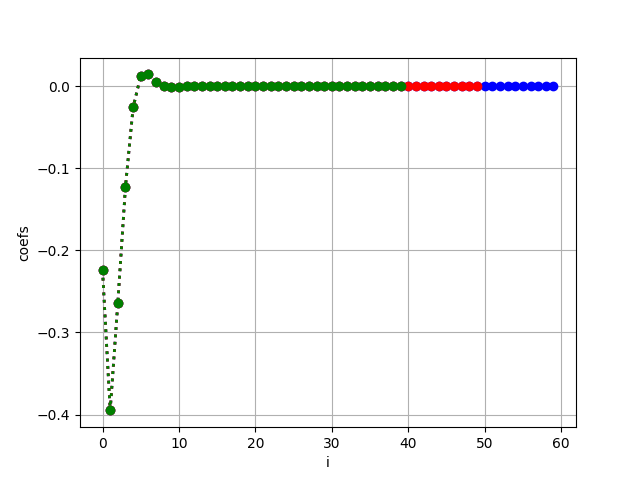

In [30]:
# ------------------------------------------------------
# --- Plot the coefficients for the envelop ---
# ------------------------------------------------------
coefs_shape_1, _, _ = compute_shape(
    Ncoefs = 60, 
    flag_plot_envelop = False, flag_plot_shape = False, flag_reconstruct = False
)
coefs_shape_2, _, _ = compute_shape(
    Ncoefs = 50, 
    flag_plot_envelop = False, flag_plot_shape = False, flag_reconstruct = False
)
coefs_shape_3, _, _ = compute_shape(
    Ncoefs = 40, 
    flag_plot_envelop = False, flag_plot_shape = False, flag_reconstruct = False
)


# --- Plotting ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(
    np.array(range(len(coefs_shape_1))), 
    coefs_shape_1, 
    color="b", linewidth = 2, linestyle=':', marker = "o"
)
ax.plot(
    np.array(range(len(coefs_shape_2))), 
    coefs_shape_2, 
    color="r", linewidth = 2, linestyle=':', marker = "o"
)
ax.plot(
    np.array(range(len(coefs_shape_3))), 
    coefs_shape_3, 
    color="g", linewidth = 2, linestyle=':', marker = "o"
)
plt.xlabel('i')
plt.ylabel("coefs")
plt.grid(True)
plt.show()

del coefs_shape_1, coefs_shape_2, coefs_shape_3

Na: 9000
max-abs-err: 4.561e-11


<IPython.core.display.Javascript object>


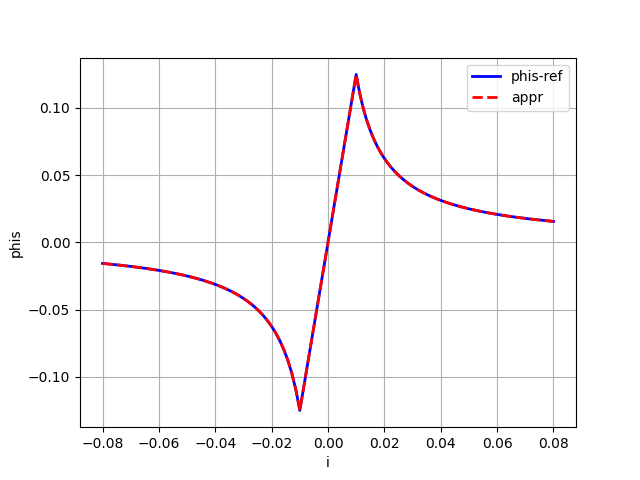

In [14]:
# -------------------------------------------------------
# --- Compute 1/x using a sequence of rotations ---
# -------------------------------------------------------
def construct_inverse_function(phis_comp, xlim = None):
    # compute the inverse function using the full set of QSVT angels:
    def compute_inverse_function(x1):
        # - W-matrix -
        xs = 1j*np.sqrt(1 - x1**2)
        W = np.array([
            [x1, xs],
            [xs, x1]
        ], dtype = complex)
    
        # - sequence of rotations -
        U = np.array(Rphi[0])
        for ia in range(1,Na):
            U = U.dot(W).dot(Rphi[ia])
        return U[0,0].real
    # -------------------------------------------------------
    Na = len(phis_comp)
    print("Na: {:d}".format(Na))
    
    kappa = dds_[id_comp_]["function-parameter"]
    
    # # corrections of the angles:
    phis_comp     -= np.pi/2.
    phis_comp[0]  += np.pi/4.
    phis_comp[-1] += np.pi/4.
    
    # x-grid:
    Nx = 101
#     x_grid_1 = np.linspace(-1.0, -1.0/kappa)
#     x_grid_2 = np.linspace(1.0/kappa, 1.0, Nx)
    
    x_grid_1 = np.linspace(-8.0/kappa, -1.0/kappa)
    x_grid_2 = np.linspace(1.0/kappa, 8.0/kappa, Nx)
    
    x_grid = np.concatenate((x_grid_1, x_grid_2))
    Nx = len(x_grid)
    
    # rotation matrices:
    Rphi = np.zeros((Na,2,2), dtype = complex)
    for ia in range(Na):
        ephi = np.exp(1j * phis_comp[ia])
        Rphi[ia,0,0] = ephi
        Rphi[ia,1,1] = np.conjugate(ephi)
    
    # odd parity:
    inv_f = np.zeros(Nx)
    for ix in range(Nx):
        inv_f[ix] = compute_inverse_function(x_grid[ix])
#     inv_f *= kappa * 1./dds_[id_comp_]["factor-norm"]
        
    # --- the reference case ---
    inv_ref = ( 1. - np.exp(-(5*kappa*x_grid)**2) ) / x_grid
    inv_ref *= dds_[id_comp_]["factor-norm"] / kappa
    
    # --- Maximum absolute error ---
    max_abs_error = np.max(np.abs(inv_ref - inv_f))
    print("max-abs-err: {:0.3e}".format(max_abs_error))
    
    # --- Plotting the computed inverse function ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_grid, inv_ref, color="b", linewidth = 2, linestyle='-', label = "phis-ref")
    ax.plot(x_grid, inv_f,   color="r", linewidth = 2, linestyle='--', label = "appr")
    plt.xlabel('i')
    plt.ylabel("phis")
    if xlim is not None:
        plt.xlim(-5, 5)
    ax.legend()
    plt.grid(True)
    plt.show()
    return
# ---------------------------------------------------------------------
phi_comp = np.array(phis_appr_)
# phi_comp = np.array(dds_[id_comp_]["phis"])

# padding_array = np.array([np.pi/2.] * 10001)
# phi_comp = np.concatenate(
#     (padding_array, phi_comp, padding_array)
# )

construct_inverse_function(phi_comp)

In [25]:
# ----------------------------------------------------------------------------------------
# --- Store the computed coefficients ---
# ----------------------------------------------------------------------------------------
from datetime import datetime
from datetime import date

# --- Current time ---
curr_time = date.today().strftime("%m/%d/%Y") + ": " + datetime.now().strftime("%H:%M:%S")

# --- Create the filename ---
full_fname = path_root_ + "/" + fname_

# --- Normalization factor used to compute the QSVT angles in the reference L-BFGS calculation:
factor_norm = dds_[id_comp_]["factor-norm"]
kappa_ref = dds_[id_comp_]['function-parameter']

# --- Store data ---
print("Storing the coefficients to:\n " + full_fname)
with h5py.File(full_fname, "w") as f:
    grp = f.create_group("basic")
    grp.create_dataset('coef_norm',           data=float(factor_norm))
    grp.create_dataset('date-of-simulation',  data=curr_time)
    grp.create_dataset('descr',  data="for-inversion")
    grp.create_dataset('param-ref',  data=float(kappa_ref))
    grp.create_dataset('N-env-half', data=int(N_half_env_))

    grp = f.create_group("coefs-amplitude")
    grp.create_dataset('real',  data = coefs_A_)

    grp = f.create_group("coefs-shape")
    grp.create_dataset('real',  data = coefs_shape_)

Storing the coefficients to:
 ./tools/QSVT-angles/inversion//QSVT-MI-estimation-coefs.hdf5


In [20]:
# ----------------------------------------------------------
# --- Store some data for plotting ---
# ----------------------------------------------------------

def save_angles(ids_phis_to_save = [0,1]):
    N_cases = len(ids_phis_to_save)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    count_plot = -1
    for id_counter in range(N_cases):
        id_case = ids_phis_to_save[id_counter]
        
        Nphis = len(dds_[id_case]["phis"]) # even integer
        x_array = np.array(range(Nphis)) - Nphis/2
        phis_ch = dds_[id_case]["phis"] - np.pi/2.
        
        mix.save_dat_plot_1d_file(
            path_save_plots_ + "/phis_k{:d}.dat".format(
                int(dds_[id_case]['function-parameter'])
            ), 
            x_array, 
            phis_ch
        )
        
        
        ax.plot(
            x_array, 
            phis_ch, 
            color=colors_[id_counter], 
            linewidth = 2, linestyle='-'
        )
        
    plt.xlabel('i - N/2')
    plt.ylabel("phis - pi/2")
    plt.grid(True)
    plt.show()
        
    return
# ---------------------------------------------------------------

save_angles()




In [6]:
dds_[0]

{'date-of-simulation': '01-22-2024 14:28:05',
 'function-type': 'inversion',
 'function-parity': 1,
 'function-parameter': 40.0,
 'abs-error': 1.1513012765362873e-13,
 'factor-norm': 0.125,
 'x': array([1.000e+00, 1.000e+00, 1.000e+00, ..., 2.182e-03, 1.309e-03,
        4.363e-04]),
 'pol-coefs': array([0.003, 0.003, 0.003, ..., 0.248, 0.158, 0.054]),
 'pol-angles': array([0.003, 0.003, 0.003, ..., 0.248, 0.158, 0.054]),
 'phis': array([1.571, 1.571, 1.571, ..., 1.571, 1.571, 1.571])}

In [11]:
print(dds_[id_comp_]["phis"][0:10] - np.pi/2.)

[-4.441e-16  4.441e-16 -2.220e-16  6.661e-16 -2.220e-16  2.220e-16
 -2.220e-16  2.220e-16  0.000e+00  4.441e-16]
